In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import joblib
import matplotlib.pyplot as plt

In [24]:
# 1. Load & Clean
df = pd.read_csv('/Users/aj/Desktop/University_Work/4A/MSE 436/Project/hotel_bookings.csv')       
df = df.drop_duplicates()
df = df.drop(columns=['agent', 'company'])
df = df[df['market_segment'] != 'Undefined']
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['total_guests'] = (
    df['adults'] + df['children'].fillna(0) + df['babies']
).astype(int)

In [25]:
# 2. Preprocess function
def preprocess(df):
    numeric = [
        'lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
        'total_nights', 'adults', 'children', 'babies', 'total_guests',
        'previous_cancellations', 'previous_bookings_not_canceled',
        'booking_changes', 'days_in_waiting_list',
        'required_car_parking_spaces', 'total_of_special_requests'
    ]
    categorical = [
        'hotel', 'meal', 'market_segment', 'distribution_channel',
        'reserved_room_type', 'deposit_type', 'customer_type'
    ]
    df_model = df[numeric + categorical + ['is_canceled']].dropna()
    df_model = pd.get_dummies(df_model, columns=categorical, drop_first=True)
    X = df_model.drop('is_canceled', axis=1)
    y = df_model['is_canceled']
    return X, y

In [26]:
# 3. Split
X, y = preprocess(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
# 4. Train Logistic Regression
model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [28]:
# 5. Cross-Validation (ROC AUC)
cv_auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"5-fold CV ROC AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

5-fold CV ROC AUC: 0.794 ± 0.004


In [29]:
# 6. Test Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")


Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.68      0.76     12675
           1       0.47      0.75      0.58      4804

    accuracy                           0.70     17479
   macro avg       0.67      0.71      0.67     17479
weighted avg       0.76      0.70      0.71     17479

Test ROC AUC: 0.791


In [30]:
# 7. Coefficient Interpretation
coefs = pd.Series(model.coef_[0], index=X_train.columns).sort_values()
top_features = pd.concat([coefs.head(10), coefs.tail(10)])
print("\nTop Positive & Negative Coefficients:")
print(top_features.to_string())


Top Positive & Negative Coefficients:
required_car_parking_spaces      -6.049366
market_segment_Offline TA/TO     -1.242505
total_of_special_requests        -0.604962
market_segment_Groups            -0.554890
distribution_channel_GDS         -0.512323
previous_bookings_not_canceled   -0.331887
booking_changes                  -0.313077
market_segment_Direct            -0.307988
market_segment_Corporate         -0.211616
customer_type_Group              -0.183624
meal_Undefined                    0.303779
reserved_room_type_C              0.369196
reserved_room_type_H              0.388702
market_segment_Online TA          0.427817
meal_FB                           0.623362
customer_type_Transient           0.751744
deposit_type_Refundable           0.829315
reserved_room_type_P              1.662841
previous_cancellations            1.902505
deposit_type_Non Refund           3.591054


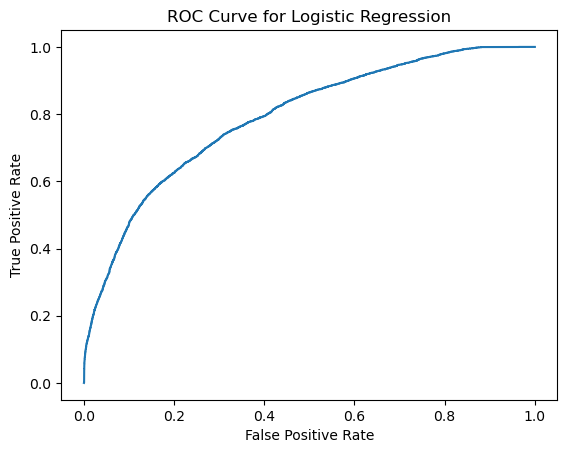

In [31]:
# 8. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()

In [32]:
# 9. Save Model
joblib.dump((model, X.columns.tolist()), 'model_section_logreg.pkl')

['model_section_logreg.pkl']